                                                                                            MSC 10/2022

# Resampling

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
    - [**Decimation and Expansion Defined**](#Decimation-and-Expansion-Defined)
    - [**Naive Downsampling**](#Naive-Downsampling) 
    - [**Aliasing**](#Aliasing)
    - [**Antialiasing Filters**](#Antialiasing-Filters)
- [**Mathematics of Downsampling**](#Mathematics-of-Downsampling)
    - [**Convolution with FIRs**](#Convolution-with-FIRs)
    - [**The Polyphase Decomposition**](#The-Polyphase-Decomposition)
- [**Downsampling in Openseize**](#Downsampling-in-Openseize) 
- [**Mathematics of Upsampling**](Mathematics-of-Upsampling)
- [**Upsampling in Openseize**](#Upsampling-in-Openseize)
- [**Resampling**](#Resampling)
- [**References**](#References)

In [1]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from openseize import producer
from openseize.io.edf import Reader
from openseize.demos import paths
from openseize.filtering.fir import Kaiser
from openseize.resampling.resampling import downsample, upsample, resample

## Introduction

There are three possible operations that can be applied to a signal to change its sampling rate. The signal may be <b>downsampled</b> from a higher to a lower sampling rate, <b>upsampled</b> from a lower to higher sampling rate, or more generally <b>resampled</b> using a ratio of upsampling to downsampling to achieve non-integer conversion of the signal's sample rate. For example, resampling from 5 KHz to 1500 Hz requries upsampling by 3 then downsampling by a factor of 10. This tutorial covers the mathematics to downsampling and the design of resamplers in Openseize. As with filtering, this topic is deep and curious readers that want to go deeper are referred to the references at the end of this tutorial.

### Decimation and Expansion Defined

At the outset, it is important that a few terms are clarified. First are <b>Decimation</b> and <b>Expansion</b>. In this tutorial we refer to <b>M-fold decimation</b> as the process of picking every Mth sample from a sequence of samples $x[n]$. Mathematically, this is expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = x[nM] \quad (1)
    $ 
</p>
<br>
<br>
As we will see this is distinct from <b>Downsampling</b>. Second, we introduce <b>L-fold expansion</b> as the insertion of L-1 zeros between each pair of samples in $x[n]$. Mathematically this is expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = x[\frac{n}{L}] = \begin{cases}
                               1 & \text{n is divisible by L} \\
                            0 & \text{otherwise}
                       \end{cases} \quad (2)
    $ 
</p>
<br>
<br>
Again this process is distinct from <b>Upsampling</b>.

### Naive Downsampling

With these definitions out of the way we will first examime how the frequency content of a signal changes when the signal is <b>decimated</b>. To do so we are going to fetch the first channel of data from our demo data. With this data we will then pick out every 25th element. Since the sample rate of the data is 5 KHz this should reduce the sampling rate to 200 Hz.

In [2]:
# lets read in the first 4 seconds of data from the demo file sampled at 5 KHz.
# if your not sure whats going on here please see the reading_files demo first
fp = paths.locate('recording_001.edf')
reader = Reader(fp)
reader.channels = [0]
fs = 5000
x = reader.read(0, 4*fs) #first 4 seconds of data

To examine the frequencies that are present in this signal, we will use the Fast Fourier Transform. 

In [3]:
# since the signal is real we use the real FFT and we build the frequencies
x_f = np.fft.rfft(x).reshape(-1,1)
x_freqs = np.fft.rfftfreq(x.shape[-1], d=1/fs)

So the plan here is to plot the frequency content of x, then decimate x by a factor of 25 and compare the frequency content with and without the decimation.

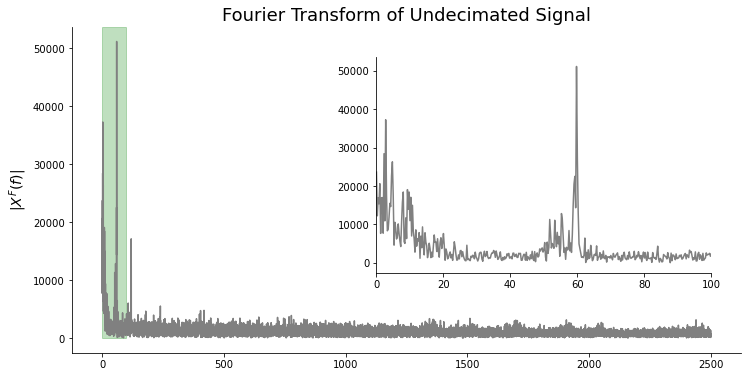

In [4]:
# plot the frequency content of the full signal and make a zoom to 100 Hz
fig, ax = plt.subplots(figsize=(12, 6))

#make axis with inset and then axarr
axinset = inset_axes(ax, width="50%", height=3, loc=1, borderpad=3)
axarr = [ax, axinset]

#plot and add rectangle for zoomed region
[ax.plot(x_freqs, np.abs(x_f), color='gray') for ax in axarr]
rect = Rectangle((0,0), 100, axarr[0].get_ylim()[-1], color='green', alpha=0.25)
axarr[0].add_patch(rect)

# set xlim of inset, labels, spines
axarr[1].set_xlim([0,100])
axarr[0].set_ylabel('$|X^F(f)|$', fontsize=14)
[ax.spines.top.set_visible(False) for ax in axarr]
[ax.spines.right.set_visible(False) for ax in axarr]
ax.set_title('Fourier Transform of Undecimated Signal', fontsize=18)

plt.show()

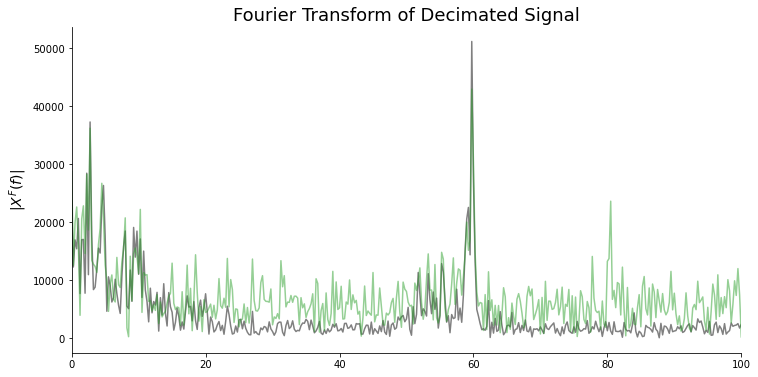

In [5]:
# Now decimate the signal by a factor of 25 reducing the sample rate from 5 KHz to 200 Hz
decimated = x[0, ::25]
decimated_f = np.fft.rfft(decimated)
decimated_freqs = np.fft.rfftfreq(decimated.shape[-1], d=1/fs * 25)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_freqs, np.abs(x_f), label='Undecimated', color='gray')
# note the factor of 25, we have 25x less signal so the amplitude drops by the decimation factor
ax.plot(decimated_freqs, 25*np.abs(decimated_f), label='25-fold Decimation', color='tab:green', alpha=0.5)

ax.set_ylabel('$|X^F(f)|$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlim([0,100])
ax.set_title('Fourier Transform of Decimated Signal', fontsize=18)
plt.show()


### Aliasing

What is going on here? Lets do a little thought experiment. Imagine a wheel with spokes that is spinning at a rate of 600 Hz and you have a strobe light that allows you to vary the freqeuncy of the light pulses. In an autoshop they call this a strobe gun. Next, you turn the lights out and start varying the frequency of the stobe gun. As you increase the frequency up towards 300 Hz (1/2 the wheels frequency) the wheel appears to slow down until you reach 300 Hz and then the wheel appears to stop! If you push the strobe gun a little above 300 Hz, the wheel then appears to rotate backwards. This phenomenon is called aliasing. The sampling done by the strobe gun has exceeded the nyquist rate (300 Hz) when this happens the frequencies in the range 300 - 600 Hz start to masqureade as lower frequencies. Hence the name aliasing.
<br>
<br>
<b>Mathematically, decimation causes the FFT to be replicated along the frequency axis.</b> If these replicates are too close (meaning the sampling exceeds the nyquist) they distort each other. This is what is occurring in our data. We have frequencies above our new nyquist of 100 Hz. All that signal from 100- 5kHz is masquerading as lower frequencies and distorting our signal. Thus, the frequency content in the range 0,100 Hz does not match the frequency content of the original signal in the same (0,100) Hz range.
<br>
<br>
Our discussion above hints at how to solve this problem. If we lowpass the data so that no signal is above 100 Hz <b>BEFORE</b> we decimate then there is no longer any high frequencies that can masquerade as low frequencies. Lets try this out. We will filter out the signal above 100 Hz then decimate and see if the frequency content of the result matches the frequency content of the original signal.

Next show that by first low-pass filtering the data we get the expected FFT after downsampling

### Antialiasing Filters

<b>The two step process of filtering then decimation is called <font color='firebrick'>Downsampling</font></b>. The filter that preceeds the M-fold decimation is called the antialias filter. It is typically designed so that the cutoff is at the new nyquist frequency. In this case that is 100 Hz. Also the width of the transition band is narrow ~ 10% of the cutoff frequency. Lets build a Kaiser filter to do just that and then decimate.

In [6]:
# Build a kaiser with the cutoff at the nyquist and set the transition width at 10% the nyquist.
kaiser = Kaiser(fpass=90, fstop=110, gpass=0.1, gstop=40, fs=5000)

#filter and decimate our signal by a factor of 25 from 5 kHz to 200 Hz
filtered = kaiser(x, chunksize=10e6, axis=-1)
antialiased = filtered[0, ::25]

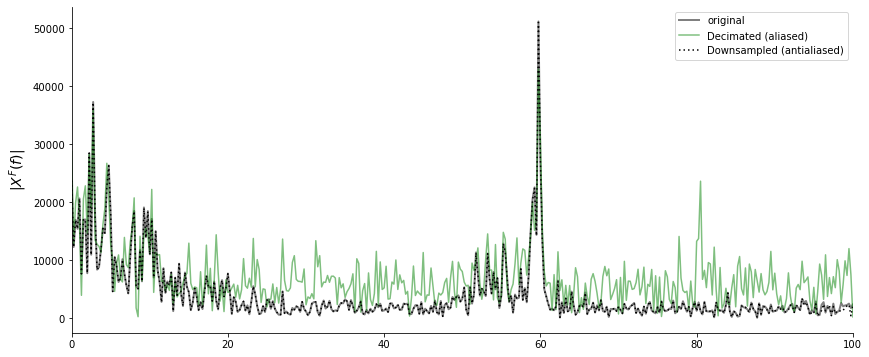

In [7]:
# Now lets again compare the frequency content of our signals
antialiased_f = np.fft.rfft(antialiased)
antialiased_freqs = np.fft.rfftfreq(antialiased.shape[-1], d=1/fs * 25)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(x_freqs, np.abs(x_f), label='original', linewidth=2, color='gray')
ax.plot(decimated_freqs, 25*np.abs(decimated_f), label='Decimated (aliased)', color='green', alpha=0.5)
ax.plot(antialiased_freqs, 25*np.abs(antialiased_f), label='Downsampled (antialiased)', color='k', 
        linestyle=(0, [1,2]))

ax.set_xlim([0,100])
ax.set_ylabel('$|X^F(f)|$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend()
plt.show()

## Mathematics of Downsampling

In the preceeding section, we found that if we filter the original data from 5 KHz to 100 Hz before decimating, the resultant signal is no longer aliased. However, this is wasteful computationally because we are filtering all the data and then throwing out 24 out of every 25 samples during the decimation step. <i><b>Do we need to compute all the filtered values before decimating?</b></i>

### Convolution with FIRs

Applying a FIR filter $h[k]$ to a data sequence $x[n]$ is a convolution expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=1}^{K} h[i] x[n-i] \quad (3)
    $ 
</p>
<br>
<br>
For each sample n, we must perform K multiplications since the filter is K elements long. Similarly, M-fold downsampling can be expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=1}^{K} h[i] x[nM-i] \quad (4)
    $ 
</p>
<br>
<br>
Which by the commutativity of convolution can be written as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=1}^{K} h[nM-i] x[i] \quad (5)
    $ 
</p>
<br>
<br>

### The Polyphase Decomposition

<b>Notice in Eqn. 5 that we need only every M filter values. So for FIR filters we can potentially reduce our computations to ~ K / M computations for each sample n. </b> To see how we can achieve this savings lets substitute into 4 (See B. Porat Ch 12):

<p style="text-align: center;">
    $
    i = i^{\prime} M + m \quad \text{where} \quad 0 \leq m \leq M-1
    $ 
</p>
giving:
<br>
<br>
<p style="text-align: center;">
    $
    \begin{align*}
    y[n] &= \sum \limits_{i=1}^{K} h[nM-i] x[i] = \sum \limits_{m=0}^{M-1} \sum \limits_{i^{\prime}} h[i^{\prime}M + m]x[nM-i^{\prime}M-m] \\
    &= \sum \limits_{m=0}^{M-1} \sum \limits_{i^{\prime}} h[i^{\prime}M + m]x[M(n-i^{\prime})-m] \quad (6)
    \end{align*}
    $ 
</p>
<br>
<br>

The effect of this substitution may not be obvious so lets work through a small example. Lets say we have a signal that we would like to down-sample by a factor of 3 and that the length of the filter h is 100 taps. 


for the m=0 terms the filter h is:
<br>
<br>
<p style="text-align: center;">
    $
    h[3i^{\prime}] = \{h[0],\ h[3],\ h[6], ... h[99]\}
    $ 
</p>
<br>
<br>
and the signal points are:
<br>
<br>
<p style="text-align: center;">
    $
    x[3(n-i^{\prime})] = \{x[3n],\ x[3n-3],\ x[3n-6], ... x[3n-99]\}
    $ 
</p>
<br>
<br>
So the convolutions for the m=0 subsequences are
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime}]x[3(n-i^{\prime})] \quad \text{for} \ m=0
    $ 
</p>
<br>
<br>

Similarly for m=1, the convolutions are:
<br>
<br>
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime} + 1]x[3(n-i^{\prime})-1] \quad \text{for} \ m=1
    $ 
</p>
<br>
<br>
and for the m=2 subsequences, the convolutions are:
<br>
<br>
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime} + 2]x[3(n-i^{\prime})-2] \quad \text{for} \ m=2
    $ 
</p>
<br>
<br>

<b>This substitution partitions the filter and subsequences into distinct subsequences</b> that are 1/3 the length of the original filter and data sequence x[n]. Thus each point in each data subsequence is only multiplied by 1/3 of the filters coeffs! These filter subsequences for each m are called the <b>polyphase components</b>.

Using our partitioning, the filtered values can be written as a sum over the convolutions of the subsequences:
<br>
<br>
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime}]x[3(n-i^{\prime})] + \sum \limits_{i^{\prime}} h[3i^{\prime} + 1]x[3(n-i^{\prime})-1] + \sum \limits_{i^{\prime}} h[3i^{\prime} + 2]x[3(n-i^{\prime})-2]
    $ 
</p>
<br>
<br>

Just to reiterate, convolution requires K multiplications for each datapoint since the filter is K-elements long. This <b>polyphase</b> decomposition approach requires only K/M multiplications + M sums. <b>Polyphase decomposition picks out the correct filter and data samples to allow us to decimate BEFORE filtering.</b> This is an M-Fold computational savings!

### Downsampling in Openseize

Openseize implements polyphase decomposition for data sequences x[n] that are too large to fit into memory. We now turn to explore how to apply this functionality in the context of downsampling.
<br>
<br>
As usual, we will start by asking for help to understand the downsample functions call signature.

In [8]:
help(downsample)

Help on function downsample in module openseize.resampling.resampling:

downsample(data, M, fs, chunksize, axis=-1, **kwargs)
    Downsamples an array or producer of arrays using polyphase
    decomposition by an integer decimation factor.
    
    Args:
        data: ndarray or producer of ndarrays
            The data to be downsampled.
        M: int
            The decimation factor describing which Mth samples of data
            survive decimation. (E.g. M=10 -> every 10th sample survives)
        fs: int
            The sampling rate of data in Hz.
        chunksize: int
            The number of samples to hold in memory during downsampling.
            This method will require ~ 3 times chunksize in memory.
        axis: int
            The axis of data along which downsampling will occur.
        kwargs:
            Any valid keyword for a Kaiser lowpass filter. The default 
            values for this antialiasing filter are:
    
                fstop: int
                 

So we need to provide a producer or array of data, the downsample factor -- this is the M-fold decimation amount, the sampling rate, the amount of samples to hold in memory during the downsampling and the sample axis. Lets build a producer for our demo data and call this function timing how long it takes to run.

In [9]:
#the reader was built above but the channel read was only the 0th. Lets downsample all the channels
reader.channels = [0,1,2,3]
pro = producer(reader, chunksize=5e6, axis=-1)
print(pro.shape)

(4, 18875000)


In [10]:
# now lets downsample the entire data (~1 hour) by 25 fold.
t0 = time.perf_counter()
polyphased = downsample(pro, M=25, chunksize=5e6, fs=5000)
elapsed = time.perf_counter() - t0
print('Producer with shape {} was downsampled in {} secs'.format(pro.shape, elapsed))

Producer with shape (4, 18875000) was downsampled in 0.00019751800209633075 secs


<b>Important</b>, remember alogirthms in Openseize are delayed execution, meaning they don't run until you actually ask for their output. Lets ask for the output and time the downsample execution...

In [11]:
t0 = time.perf_counter()
polyresult = polyphased.to_array()
elapsed = time.perf_counter() - t0
print('Producer with shape {} was downsampled in {} secs'.format(pro.shape, elapsed))

Producer with shape (4, 18875000) was downsampled in 3.6685728289994586 secs


Great so we see that the downsampling of 4 channels of data of 1 hour duration took almost 4 secs. Lets compare the first 4-secs of this polyphased downsample data with the 4 secs of downsampled data computed by filtering then decimation from the aliasing section of this demo.

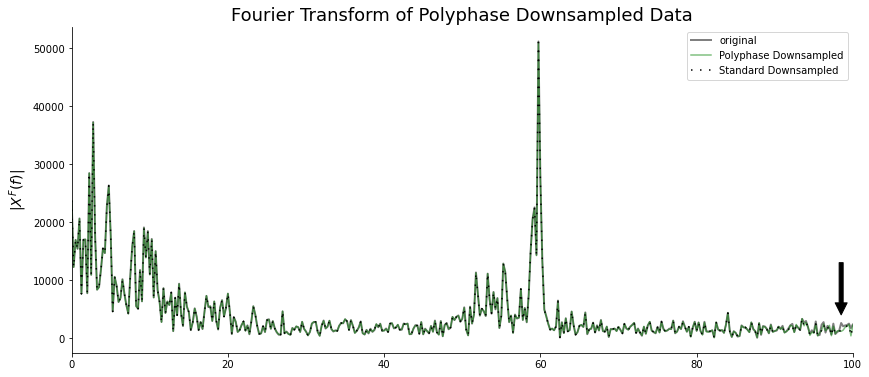

In [12]:
# get the first 4 secs of openseizes polyphase result and get its Fourier representation
pp = polyresult[0, 0:int(4*fs/25)]
pp_f = np.fft.rfft(pp)
pp_freqs = np.fft.rfftfreq(pp.shape[-1], d=1/fs * 25)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot the original (not downsampled) FFT of the first 4 secs of data
ax.plot(x_freqs, np.abs(x_f), label='original', linewidth=2, color='gray')

# Plot the FFT of the first 4 seconds of polyphase downsampled data
ax.plot(pp_freqs, 25*np.abs(pp_f), label='Polyphase Downsampled', color='green', alpha=0.5)

# Plot the FFT of the filtered and decimated (antialiased from above) first 4 secs of data
ax.plot(antialiased_freqs, 25*np.abs(antialiased_f), label='Standard Downsampled', color='k', 
        linestyle=(0, [1,5]))

ax.set_xlim([0,100])
ax.set_ylabel('$|X^F(f)|$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend()
ax.annotate('',(98.5, 4000), xytext=(98.5, 13000), arrowprops=dict(facecolor='k'))
ax.set_title('Fourier Transform of Polyphase Downsampled Data', fontsize=18)
plt.show()

The frequency content of the original, polyphase, and standard downsampled data are all very close. Notice around 100 Hz (see arrow), the standard and polyphase downsampling deviate slightly from the original frequency content in x[n]. This is due to the Kaiser filter used in both the standard and polyphase algorithms. The Kaiser filter's transfer function $H^f(\theta)$ has some width around the 100 Hz cutoff causing a slight deviation there. 

## Mathematics of Upsampling

As a reminder expansion is the insertion of L-1 zeros between each of the samples in x[n].
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = x[\frac{n}{L}] = \begin{cases}
                               1 & \text{n is divisible by L} \\
                            0 & \text{otherwise}
                       \end{cases}
    $ 
</p>
<br>
<br>

The result of this operation is pretty useless until we replace the zeros with <b>Interpolated</b> values. How do we interpolate the signal at each zero? <b>Interpolation is carried out by low-pass filtering the expanded sequence x[n].</b> L-fold expansion followed by filtering is expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=0}^K h[i] x[n-Li] = \sum \limits_{i=0}^K x[i] h[n-Li] \quad (7)
    $ 
</p>
<br>
<br>

Here the filter h is zero everywhere except where the sample indices "n" are divisible by L. Thus as with decimation we have the potential for a L-fold computational savings. This is equivalent to saying we can filter before we expand the sequence x[n]. This saves us from filtering L zeros for every non-zero data sample. As with decimation, there is a clever substitution that helps us achieve this savings. In this case we substitute n with:

<p style="text-align: center;">
    $
    n = n^{\prime}L + L - 1- l \quad \text{where} \quad 0 \leq l \leq L-1 \quad (8)
    $ 
</p>
giving <b>for each l</b>:
<br>
<br>
<p style="text-align: center;">
    $
    y[n^{\prime}L + L - 1- l] = \sum \limits_{i=0}^K x[i] h[(n^{\prime}-i)L + L - 1 - l] \quad (9)
    $ 
</p>
<br>
<br>

As with the decimation, the filter is broken into subsequences where each subsequence is a distinct subsequence because they are shifted by different l's and then only every Lth term survives. This gives us the K / L computational savings. We sum the $y[n^{\prime}L + L - 1- l]$ terms across l-values to get each y[n]. 
<br>
<br>
<b>Important, upsampling does not lead to aliasing. While expansion leads to replicates in the Fourier domain, these replicates are always spaced far enough apart along the frequency axis so as not to interfere with each other. </b>
<br>
<br>
Since this upsampling polyphase decomposition is similar to downsampling, we won't work out a specific example but if you set the L-fold upsample to L=3, you will find the argument follows closely what we did for downsampling. Lets now turn to using Openseize's upsample

## Upsampling in Openseize

As usual start by asking for help

In [13]:
help(upsample)

Help on function upsample in module openseize.resampling.resampling:

upsample(data, L, fs, chunksize, axis=-1, **kwargs)
    Upsamples an array or producer of arrays using polyphase
    decomposition by an integer expansion factor.
    
    Args:
        data: ndarray or producer of ndarrays
            The data to be downsampled.
        L: int
            The expansion factor. L-1 interpolated values will be inserted
            between consecutive samples in data along axis.
        fs: int
            The sampling rate of data in Hz.
        chunksize: int
            The number of samples to hold in memory during upsampling.
            This method will require ~ 3 times chunksize in memory.
        axis: int
            The axis of data along which upsampling will occur.
        kwargs:
            Any valid keyword for a Kaiser lowpass filter. The default 
            values for this interpolation filter are:
    
                fstop: int
                    The stop band edg

In [14]:
# lets take our 4 seconds of data x and upsample  L=3 fold

# notice we are supplying the array this time instead of a producer for variety
# also notice the chunksize is larger than array size along last axis so this means 
# 'use the entire array at once'
t0 = time.perf_counter()

upsampled_x = upsample(x, L=3, fs=fs, chunksize=10e6, axis=-1)

elapsed = time.perf_counter() - t0
print('Array with shape {} was downsampled in {} secs'.format(x.shape, elapsed))

Array with shape (1, 20000) was downsampled in 0.005702343001757981 secs


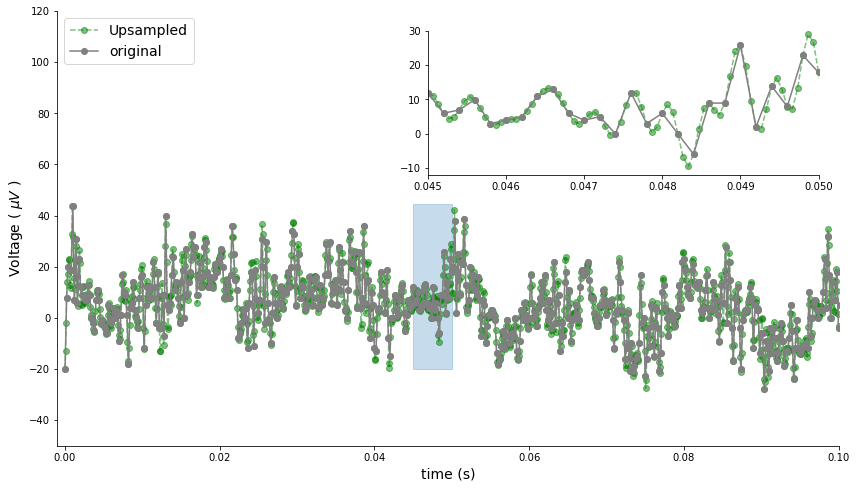

In [15]:
# and lets make a plot to convince ourselves that the upsampling is working right
fig, ax = plt.subplots(figsize=(14, 8))

times = np.arange(0, 4, 1/fs)
up_times = np.arange(0, 4, 1/(fs*3))

axinset = inset_axes(ax, width="50%", height=2, loc=1, borderpad=2)
axarr = [ax, axinset]

# plot the original and upsampled to each axis and remove spines
[ax.plot(up_times, upsampled_x[0], marker='o', linestyle='--', color='green', alpha=0.5, 
         label='Upsampled') for ax in axarr]
[ax.plot(times, x[0], marker='o', color='gray', label='original') for ax in axarr]
[ax.spines.top.set_visible(False) for ax in axarr]
[ax.spines.right.set_visible(False) for ax in axarr]

# add rectangle to indicate zoomed region
rect = Rectangle((.045, -20), .005, axarr[0].get_ylim()[-1], color='tab:blue', alpha=0.25)
axarr[0].add_patch(rect)

#set axis limits
axarr[0].set_xlim([-0.001,0.1])
axarr[0].set_ylim([-50, 120])
axarr[1].set_xlim([0.045,0.05])
axarr[1].set_ylim([-12,30])

#set labels and plot
axarr[0].set_ylabel(r'Voltage $(\ \mu V \ )$', fontsize=14)
axarr[0].set_xlabel('time (s)', fontsize=14)
axarr[0].legend(loc='upper left', fontsize=14)
plt.show()

So we can see that between each pair of original data samples we now have two interpolated points giving us an upsample of 3-fold (i.e. original samples are now spaced 3 samples apart). One last point to make about upsampling is that <b>upsampling does not increase the information content</b> the interpolated samples are just that; they are interpolated. So be careful drawing conclusions that rely on samples that were interpolated.

## Resampling

So far, we have only considered downsampling by an integer factor M or upsampling by an integer factor L. <b> What if we want to resample data by a non-integer rational number.</b> For example lets say our data is sampled at 5 KHz but we would like to resample the data to 2 kHz. We can't simply downsample this data because 5 divided by 2 is not an integer; we can't downsample by 2.5. So what can we do? Notice that if we upsampled our 5 KHz data by 2 and then downsampled by 5 we would get 2 KHz. This is the basis for <b>resampling</b>. We form a rational upsample to downsample ratio of L / M.

Polyphase decomposition resampling can be accomplished by combining the downsample and upsample polyphase implementations discussed earlier in this demo. Briefly, we make the following substitution:
<br>
<br>
<p style="text-align: center;">
    $
    n = n^{\prime}L + l \quad \text{where} \quad 0 \leq l \leq L-1 \quad (10)
    i = i^{\prime} M + m \quad \text{where} \quad 0 \leq m \leq M-1 \quad (11)
    $ 
</p>
<br>
<br>
Notice the similarity with the up and downsample substitutions Eqns 6 and 8. With these substitutions into our standard FIR convolution (Eqn 3). We obtain for each l:
<br>
<br>
<p style="text-align: center;">
    $
    y[n^{\prime}L+l] = \sum \limits_{m=0}^{M-1} \sum \limits_{i=0}^{K} x[i^{\prime}M + m] \ 
                       h[(n^{\prime}-i^{\prime})ML + lM - mL] \quad (12)
    $ 
</p>
<br>
<br>
Although the effect of this substitution is not immediately apparent, you can see that we are picking out M distinct subsequences of the data x[n] and that the filter is being broken into distint subsequences for the MLth elements shifted by l and m. Its a little complicated and the curious reader is encouraged to see all the details and simplification of this substitution in B. Porat's <i>A Course in Digital Signal Processing </i> Ch 12.
<br>
<br>
Openseize implements this polyphase decomposition for resampling data. So lets now turn to how users can use this functionality. Again we will ask for help to see the call signature of resample.

In [16]:
help(resample)

Help on function resample in module openseize.resampling.resampling:

resample(data, L, M, fs, chunksize, axis=-1, **kwargs)
    Resamples an array or producer of arrays using polyphase 
    decomposition by a rational factor L / M.
    
    Args:
        data: ndarray or producer of ndarrays
            The data to be resampled.
        L: int
            The expansion factor. L-1 interpolated values will be inserted
            between consecutive samples in data along axis.
        M: int
            The decimation factor describing which Mth samples of data
            survive decimation. (E.g. M=10 -> every 10th sample survives)
        fs: int
            The sampling rate of data in Hz.
        chunksize: int
            The number of samples to hold in memory during upsampling.
            This method will require ~ 3 times chunksize in memory.
        axis: int
            The axis of data along which resampling will occur.
        kwargs:
            Any valid keyword for a K

In [20]:
reader.channels = [0,1,2,3]
pro = producer(reader, chunksize=5e6, axis=-1)
print(pro.shape)

(4, 18875000)


In [23]:
rpro = resample(pro, L=32, M=625, fs=5000, chunksize=5e6)
t0 = time.perf_counter()
arr = rpro.to_array()
elapsed = time.perf_counter() - t0
print('Producer with shape {} was resampled in {} secs'.format(pro.shape, elapsed))

Producer with shape (4, 18875000) was resampled in 3.698658207002154 secs


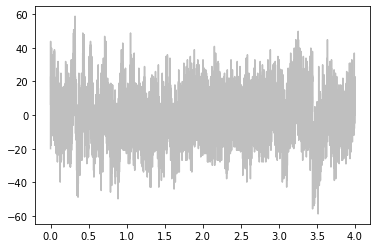

In [35]:
y = arr[0, 0:4*3000]
fig, ax = plt.subplots()
times = np.arange(0, 4, 1/5000)
ax.plot(times, x[0], color='gray', alpha=0.5)
#ax.plot(y, alpha=0.2, color='blue')
plt.show()